In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import glob
from focal_loss import BinaryFocalLoss

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [2]:
batch_size = 32
epochs = 10

# Build simple cnn model

In [3]:
def build_model(input_shape=(224, 224, 3), num_classes=27, is_pretrained=True):
    if not is_pretrained:
        body = tf.keras.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten()
        ], name='normal_conv')
    else:
        mobilenet_body = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
        mobilenet_body.trainable = False
        
        body = tf.keras.Sequential([
            mobilenet_body,
            tf.keras.layers.GlobalAveragePooling2D()
        ], name='mobilenet_body')
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        body,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [4]:
model = build_model(is_pretrained=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_body (Sequential)  (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                6939      
Total params: 2,592,859
Trainable params: 334,875
Non-trainable params: 2,257,984
_________________________________________________________________


In [5]:
model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(),
    loss=BinaryFocalLoss(gamma=2),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Load Data for use
- First split to train and test
- Load as a tf dataset 

In [6]:
df = pd.read_csv('data/MovieGenre.csv')
images = glob.glob('data/downloaded_posters/*.jpg')

In [7]:
df = df.dropna(subset=['Genre'])

In [8]:
df['labels'] = df['Genre'].apply(lambda x: x.split('|'))

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2021)

In [10]:
train_image = []
train_labels = []

test_image = []
test_labels = []

for val in train_df.itertuples(index=False):
    image_name = 'data/downloaded_posters/' + str(val.imdbId) + '.jpg'
    if os.path.exists(image_name):
        train_image.append(image_name)
        train_labels.append(val.labels)
        
for val in test_df.itertuples(index=False):
    image_name = 'data/downloaded_posters/' + str(val.imdbId) + '.jpg'
    if os.path.exists(image_name):
        test_image.append(image_name)
        test_labels.append(val.labels)

In [11]:
binarizer = MultiLabelBinarizer().fit(train_labels)
train_labels = binarizer.transform(train_labels)
test_labels = binarizer.transform(test_labels)

/home/superceed1/anaconda3/envs/py38tf23/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['Game-Show'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [12]:
index_label = dict([(index, cls) for index, cls in enumerate(binarizer.classes_)])

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image, test_labels))

In [14]:
# Mobilenet requires a -1 to 1 range of values
@tf.function
def read_data(image, labels):
    img = tf.io.decode_jpeg(tf.io.read_file(image), channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    
    return (img / 127.5) - 1, tf.cast(labels, tf.float32)

In [15]:
train_dataset = train_dataset.shuffle(len(train_dataset)).map(
    read_data, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(
    read_data, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Train & Plot History

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights/{epoch:02d}-genre-{val_accuracy:.2f}.h5', monitor='val_accuracy')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3)

In [17]:
history = model.fit(
    train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[checkpoint, earlystopping]
)

Epoch 1/10
924/924 [==============================] - 46s 50ms/step - loss: 0.0721 - accuracy: 0.2528 - auc: 0.7739 - precision: 0.3687 - recall: 0.2213 - val_loss: 0.0575 - val_accuracy: 0.3341 - val_auc: 0.8438 - val_precision: 0.5938 - val_recall: 0.1910
Epoch 2/10
924/924 [==============================] - 45s 49ms/step - loss: 0.0594 - accuracy: 0.3167 - auc: 0.8340 - precision: 0.5343 - recall: 0.2298 - val_loss: 0.0555 - val_accuracy: 0.3436 - val_auc: 0.8573 - val_precision: 0.5999 - val_recall: 0.2372
Epoch 3/10
924/924 [==============================] - 45s 49ms/step - loss: 0.0565 - accuracy: 0.3393 - auc: 0.8516 - precision: 0.5733 - recall: 0.2406 - val_loss: 0.0546 - val_accuracy: 0.3578 - val_auc: 0.8642 - val_precision: 0.6110 - val_recall: 0.2503
Epoch 4/10
924/924 [==============================] - 45s 49ms/step - loss: 0.0548 - accuracy: 0.3528 - auc: 0.8624 - precision: 0.5997 - recall: 0.2487 - val_loss: 0.0540 - val_accuracy: 0.3579 - val_auc: 0.8678 - val_precisi

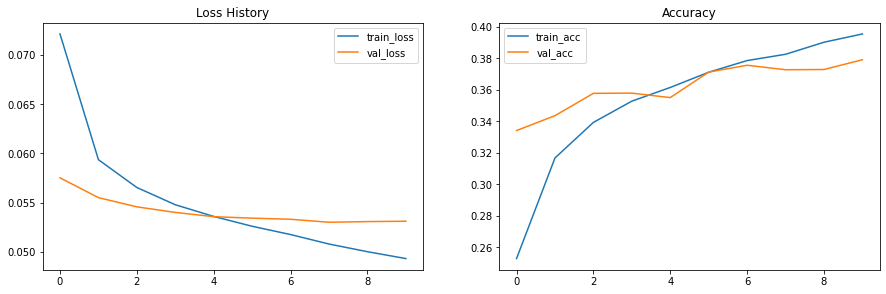

In [18]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.title('Loss History')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

# Evaluate model

In [19]:
y_pred = model.predict(test_dataset)

In [20]:
print(classification_report(test_labels, y_pred > 0.3))

              precision    recall  f1-score   support

           0       0.23      0.81      0.36      1027
           1       0.00      0.00      0.00         1
           2       0.19      0.71      0.30       713
           3       0.39      0.68      0.49       335
           4       0.10      0.15      0.12       379
           5       0.35      0.97      0.51      2376
           6       0.18      0.79      0.29       973
           7       0.20      0.66      0.31       675
           8       0.51      1.00      0.67      3721
           9       0.19      0.53      0.28       361
          10       0.16      0.41      0.22       419
          11       0.21      0.11      0.15        80
          12       0.09      0.06      0.07       270
          13       0.23      0.79      0.36       756
          14       0.09      0.07      0.08       239
          15       0.10      0.13      0.11       142
          16       0.14      0.39      0.21       496
          17       0.00    

/home/superceed1/anaconda3/envs/py38tf23/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

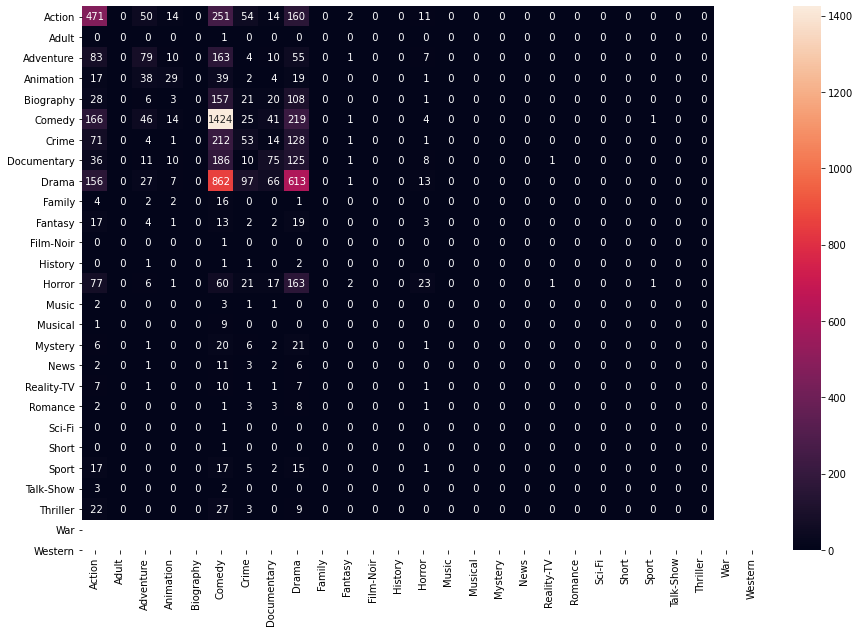

In [21]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(y_pred >= 0.4, axis=1)), 
    annot=True, fmt='3', xticklabels=binarizer.classes_, yticklabels=binarizer.classes_
)

In [22]:
f1_score(np.argmax(test_labels, axis=1), np.argmax(y_pred >= 0.4, axis=1),average='micro')

0.3740200054068667

# Inspect visuallly

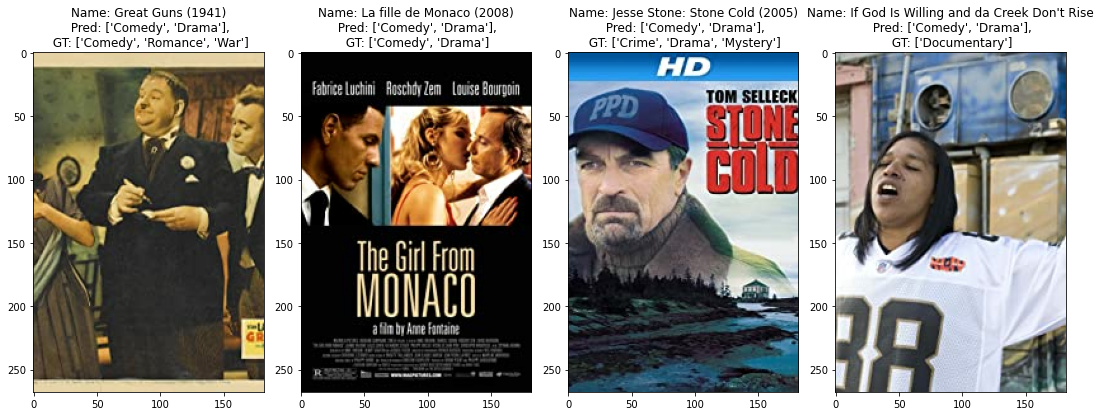

In [23]:
count = 0
plt.figure(figsize=(15, 10))
for val in test_df.sample(4).itertuples(index=False):
    image_name = 'data/downloaded_posters/' + str(val.imdbId) + '.jpg'
    if os.path.exists(image_name):
        img = tf.io.decode_jpeg(tf.io.read_file(image_name))
        img_norm = tf.cast(img, tf.float32)
        img_norm = tf.image.resize(img_norm, [224, 224])
        img_norm = (img_norm / 127.5) - 1
        genres = model.predict(tf.expand_dims(img_norm, axis=0))
        
        title_genre = []
        selected_genre = np.where(genres >= 0.4)[1]
        for g in selected_genre:
            title_genre.append(index_label[g])
        
        count += 1
        plt.subplot(1, 4, count)
        plt.title('Name: {}\n Pred: {},\n GT: {}'.format(val.Title, title_genre, val.labels))
        plt.imshow(img)
        
plt.tight_layout()